<a href="https://colab.research.google.com/github/Ryan-Gsec/DeepLearn/blob/main/HW1-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)


Using the TorchVision library, we can easily perform image preprocessing.

`transforms.Compose()`: A collection of methods for transforming images.

`transforms.RandomResizedCrop()`: Resizes the input image to the specified size (224x224). Additionally, it randomly crops the image with an area between 50% to 100% of the original size.

`transforms.RandomHorizontalFlip()`: Randomly flips the image horizontally with a default probability of 0.5.

`transforms.ToTensor()`: When reading the image using PIL, each pixel value falls within the range of 0 to 255, and the image is represented in the format height x width x channels. By using `transforms.ToTensor()`, the image is converted to float values within the range of 0 to 1, and its dimensions are represented as channels x height x width.

`transforms.Normalize()`: Normalizes the image using the standard score. In this case, the mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225) of the ImageNet dataset are used for normalization.

In [5]:
from google.colab import files #
file_uploaded=files.upload()

Saving HW1-1_data.zip to HW1-1_data.zip


In [6]:
!unzip HW1-1_data.zip -d HW1-1_data/

Archive:  HW1-1_data.zip
  inflating: HW1-1_data/HW1-1_data/rot/rot (34).JPG  
  inflating: HW1-1_data/HW1-1_data/rot/rot (45).JPG  
  inflating: HW1-1_data/HW1-1_data/rot/rot (76).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (78).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (61).JPG  
  inflating: HW1-1_data/HW1-1_data/rot/rot (73).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (51).JPG  
  inflating: HW1-1_data/HW1-1_data/rot/rot (49).JPG  
  inflating: HW1-1_data/HW1-1_data/rot/rot (72).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (74).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (46).JPG  
  inflating: HW1-1_data/HW1-1_data/rot/rot (66).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (59).JPG  
  inflating: HW1-1_data/HW1-1_data/rot/rot (71).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (75).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (70).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (64).jpg  
  inflating: HW1-1_data/HW1-1_data/rot/rot (60).JPG  
  i

In [7]:
blotch = '/content/HW1-1_data/HW1-1_data/blotch'
normal = '/content/HW1-1_data/HW1-1_data/normal'
rot = '/content/HW1-1_data/HW1-1_data/rot'
scab = '/content/HW1-1_data/HW1-1_data/scab'

blotch_images_filepaths = sorted([os.path.join(blotch, f) for f in os.listdir(blotch)])
normal_images_filepaths = sorted([os.path.join(normal, f) for f in os.listdir(normal)])
rot_images_filepaths = sorted([os.path.join(rot, f) for f in os.listdir(rot)])
scab_images_filepaths = sorted([os.path.join(scab, f) for f in os.listdir(scab)])
images_filepaths = [*blotch_images_filepaths, *normal_images_filepaths, *rot_images_filepaths, *scab_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

#random.seed(42)
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:288]
val_images_filepaths = correct_images_filepaths[288:310]
test_images_filepaths = correct_images_filepaths[-10:]

print('train:', len(train_images_filepaths))
print('val:', len(val_images_filepaths))
print('test:', len(test_images_filepaths))

train: 288
val: 22
test: 10


In [8]:
class apple(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-2]
        if label == 'blotch':
            label = 0
        elif label == 'normal':
            label = 1
        elif label == 'rot' :
            label = 2
        elif label == 'scab' :
            label = 3
        return img_transformed, label


In [9]:
size = 224
mean = (0.485, 0.456, 0.406) # RGB
std = (0.229, 0.224, 0.225) #RGB
batch_size = 32
train_dataset = apple(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = apple(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print('image size:', train_dataset.__getitem__(index)[0].size())
print('image label:', train_dataset.__getitem__(index)[1])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

image size: torch.Size([3, 224, 224])
image label: 0
torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 2, 1, 0, 3, 3, 3, 3, 2, 0, 1, 1, 3, 3, 1, 1, 1, 2, 1, 0, 2, 2,
        2, 1, 3, 2, 2, 3, 3, 3])


In [10]:

class LeNet(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)  # BatchNorm2d after the first convolutional layer
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)  # BatchNorm2d after the second convolutional layer
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.bn3 = nn.BatchNorm1d(512)  # BatchNorm1d before the first fully connected layer
        self.relu5 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)  # Adding dropout layer with dropout_rate
        self.fc2 = nn.Linear(512, 4)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)

        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.relu5(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [11]:
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu5): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (output): Softmax(dim=1)
)


In [12]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
       BatchNorm2d-2         [-1, 16, 220, 220]              32
              ReLU-3         [-1, 16, 220, 220]               0
         MaxPool2d-4         [-1, 16, 110, 110]               0
            Conv2d-5         [-1, 32, 106, 106]          12,832
       BatchNorm2d-6         [-1, 32, 106, 106]              64
              ReLU-7         [-1, 32, 106, 106]               0
         MaxPool2d-8           [-1, 32, 53, 53]               0
            Linear-9                  [-1, 512]      46,023,168
      BatchNorm1d-10                  [-1, 512]           1,024
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                    [-1, 4]           2,052
          Softmax-14                   

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [14]:
import time

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    # Lists to store loss and accuracy for plotting
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Store loss and accuracy for plotting
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc.item())
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Plot the loss and accuracy graphs
    plt.figure()
    plt.plot(range(1, num_epoch + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epoch + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

    plt.figure()
    plt.plot(range(1, num_epoch + 1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, num_epoch + 1), val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()

    return model


Epoch 1/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.2959 Acc: 0.4271


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.2831 Acc: 0.5909
Epoch 2/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.1242 Acc: 0.6389


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.1910 Acc: 0.5455
Epoch 3/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.0517 Acc: 0.7361


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0913 Acc: 0.7273
Epoch 4/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.0307 Acc: 0.7569


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0414 Acc: 0.7727
Epoch 5/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.0175 Acc: 0.7604


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0296 Acc: 0.7727
Epoch 6/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9918 Acc: 0.7986


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0123 Acc: 0.7727
Epoch 7/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9724 Acc: 0.7917


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.9725 Acc: 0.7727
Epoch 8/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9693 Acc: 0.8160


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0063 Acc: 0.6818
Epoch 9/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9709 Acc: 0.8194


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0042 Acc: 0.7273
Epoch 10/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9486 Acc: 0.8264


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.9935 Acc: 0.7727
Epoch 11/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9395 Acc: 0.8472


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0191 Acc: 0.6818
Epoch 12/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9323 Acc: 0.8507


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0213 Acc: 0.7273
Epoch 13/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9220 Acc: 0.8681


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0417 Acc: 0.6818
Epoch 14/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9360 Acc: 0.8438


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0072 Acc: 0.7273
Epoch 15/15
--------------------


  0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.9296 Acc: 0.8472


  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.0223 Acc: 0.7273
Training complete in 3m 46s
Best val Acc: 0.772727


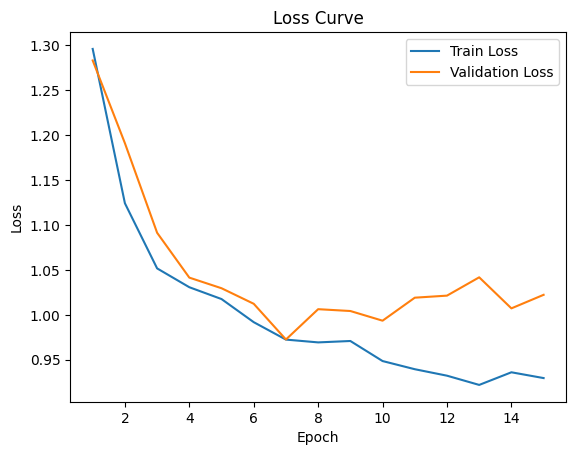

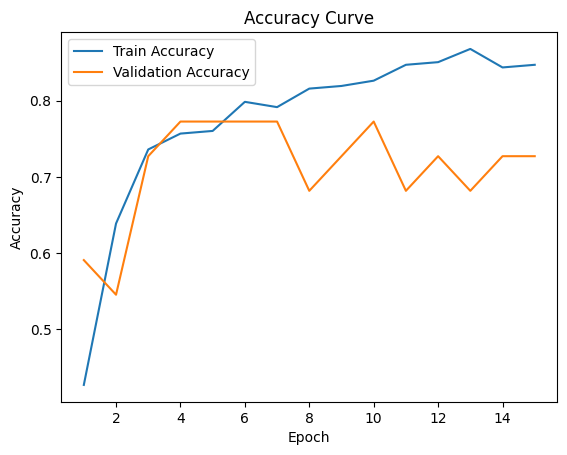

In [15]:
num_epoch = 15
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

In [16]:
import pandas as pd

corrects = 0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        label = test_path.split('/')[-2]  # Get the class label from the folder name
        if label == 'blotch':
            label = 0
        elif label == 'normal':
            label = 1
        elif label == 'rot':
            label = 2
        elif label == 'scab':
            label = 3

        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        corrects += torch.sum(preds == label)

acc = (corrects.double() / len(test_images_filepaths)).cpu().numpy()
print('Test Acc: {:.4f}'.format(acc))



  0%|          | 0/10 [00:00<?, ?it/s]

Test Acc: 0.9000
